# Exploring Different Spots and Venues in Jaipur, Rajasthan, India

## Contents
1. Introduction
2. Data Collection from different sources
3. Data Cleaning
4. Methodology
5. Analysis
6. Results
7. Conclusion and Future Scope

#### Importing all the libraries which we will needed in our notebook

In [4]:
import numpy as np # library to handle data in a vectorized manner
import pandas as pd  # library for data analsysis
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

# Matplotlib and associated plotting modules
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors

import json

!conda install -c conda-forge geopy --yes 
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# import k-means from clustering stage
from sklearn.cluster import KMeans

#!conda install -c conda-forge folium=0.5.0 --yes
import folium # map rendering library

print('Libraries imported.')

Solving environment: done

## Package Plan ##

  environment location: /home/jupyterlab/conda/envs/python

  added / updated specs:
    - geopy


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    geographiclib-1.50         |             py_0          34 KB  conda-forge
    geopy-1.21.0               |             py_0          58 KB  conda-forge
    openssl-1.1.1g             |       h516909a_0         2.1 MB  conda-forge
    ------------------------------------------------------------
                                           Total:         2.2 MB

The following NEW packages will be INSTALLED:

  geographiclib      conda-forge/noarch::geographiclib-1.50-py_0
  geopy              conda-forge/noarch::geopy-1.21.0-py_0

The following packages will be UPDATED:

  openssl                                 1.1.1f-h516909a_0 --> 1.1.1g-h516909a_0



openssl-1.1.1g       | 2.1 MB    | ############

## 1. Introduction

Jaipur, popularly known as the "Pink City", is the capital of Rajasthan state, India. Jaipur is worldwide famous for unique Architecture, Forts, Monuments, Palaces, Art and Craft, Culture and for its unique Food. It is one of the greatest tourist places in India to visit. So, many foreign and indian tourists visit this city regularly.

So, I decided to analyze the different venues and spots especially food spots and hotel so that anyone who will come to visit this beautiful place can easily find out the food venues and places to stay at the the price that is affordable for them and have good ratings.

Here, we'll identify places that are fit for various individuals based on the information collected. Once we have the different plots, any company or startup or any entrpereneur can launch an application using the same data and suggest users such information and can start a new cafe, hotel, other spots, etc.

#### Jaipur Map

Let's use the folium library to create a complete map zoomed on Jaipur using latitude and longitude value of the Jaipur city. And for fetching the latitude and longitude of Jaipur we use the geopy library and do the work. We'll also plot a marker on the coordinates we just identified above. This would give us a relatively good look at the center point we will be considering.

Function to get geolocation of any address

In [5]:
def geo_location(address):
    geolocator = Nominatim(user_agent="my-application")
    location = geolocator.geocode(address)
    latitude = location.latitude
    longitude = location.longitude
    return latitude,longitude

In [6]:
jaipur_lat, jaipur_long = geo_location('Jaipur City, Rajasthan, India')
print('The geograpical coordinates of Jaipur are {}, {}.'.format(jaipur_lat, jaipur_long))

The geograpical coordinates of Jaipur are 26.916194, 75.820349.


In [7]:
jaipur_map = folium.Map(location = [jaipur_lat, jaipur_long], zoom_start = 13)
folium.Marker([jaipur_lat, jaipur_long]).add_to(jaipur_map)
jaipur_map.save("maps/Jaipur Map.html")
jaipur_map

## 2. Data Collection from different sources

Now, after taking the view of the map we will collect the data of the different venues of Jaipur city. 
We will fetch the data from two different APIs.
Foursquare API: We will use the Foursquare API to fetch venues in Jaipur starting from the middle upto 6 Kilometers in each direction.
Zomato API: The Zomato API provides information about various venues including the complete address, user ratings, average price and a lot more.

#### FourSquare API

We begin by fetching venues in Jaipur upto a range of 6 Kilometers using the Foursquare API. The Foursquare API has the explore API which allows us to find venue recommendations within a given radius from the given coordinates. We will use this API to find the number of venues we need to explore.

Now we will define credentials for foursquare api

In [8]:
CLIENT_ID = 'PBAULO215YBB4MQ2S1RMPO4UV43L1CZR4HBXJ2ZRC221IG3F' # your Foursquare ID
CLIENT_SECRET = '3CKTJS1WR5J2P0LL3C3SXSJ1Q4E0WWPGEUYFCCBSR4FQ4BSY' # your Foursquare Secret
RADIUS = 6000 # 6 Km
NO_OF_VENUES = 100 #no. of venues
VERSION = '20200505' # Foursquare API version

We define the get_category_type method to get the correct category for each venue.

In [9]:
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

We'll call the API over and over till we get all venues from the API within the given distance. The maximum venues this API can fetch is 100.
Foursquare API requires client_id, and client_secret to function which can be accessed after creating a developer account.
We will set the radius as 6 Kilometers.
The version is a required parameter which defines the date on which we are browsing so that it retrieves the latest data.

In [10]:
foursquare_venues = pd.DataFrame(columns = ['name', 'categories', 'lat', 'lng'])


url = ('https://api.foursquare.com/v2/venues/explore?client_id={}'
           '&client_secret={}&v={}&ll={},{}&radius={}&limit={}').format(CLIENT_ID, 
                                                                        CLIENT_SECRET, 
                                                                        VERSION, 
                                                                        jaipur_lat, 
                                                                        jaipur_long, 
                                                                        RADIUS,
                                                                        NO_OF_VENUES)
result = requests.get(url).json()
venues_fetched = len(result['response']['groups'][0]['items'])

venues = result['response']['groups'][0]['items']
venues = pd.json_normalize(venues)

# Filter the columns
filtered_columns = ['venue.name', 'venue.categories', 'venue.location.lat', 'venue.location.lng']
venues = venues.loc[:, filtered_columns]

# Filter the category for each row
venues['venue.categories'] = venues.apply(get_category_type, axis = 1)

# Clean all column names
venues.columns = [col.split(".")[-1] for col in venues.columns]
foursquare_venues = pd.concat([foursquare_venues, venues], axis = 0, sort = False)
    
foursquare_venues = foursquare_venues.reset_index(drop = True)
print("Total {} venues fetched within a total radius of {} Km".format(venues_fetched, RADIUS/1000))

Total 100 venues fetched within a total radius of 6.0 Km


#### Zomato API

The Zomato API allows using its search API to search for any given venue based on certain search filters. Zomato also requires a Zomato user key which can be accessed by creating a developer account for it.

We'll use the name, lat, and lng values of various venues fetched from Foursquare API to use the search API and get more information regarding each venue.

The different parameters provide different information for calling the api.
The query will be the name of the venue.
The start defines from what offset we want to start, so we'll keep it at 0.
The count defines the number of restaurants we want to fetch. As we have the exact location coordinates, we'll fetch only one.
We will supply the latitude and longitude values.
We will set the sorting criteria as real_distance so each time we get the venue we're searching based on location coordinates

In [11]:
#key for the zomato api
headers = {'user-key': 'd18161d53d3a2cf98890d296054b88cc'}
venues_information = []

for index, row in foursquare_venues.iterrows():
    print("Fetching data for venue: {}".format(index + 1))
    venue = []
    url = ('https://developers.zomato.com/api/v2.1/search?q={}' + 
          '&start=0&count=1&lat={}&lon={}&sort=real_distance').format(row['name'], row['lat'], row['lng'])
    result = requests.get(url, headers = headers).json()
    if (len(result['restaurants']) > 0):
        venue.append(result['restaurants'][0]['restaurant']['name'])
        venue.append(result['restaurants'][0]['restaurant']['location']['latitude'])
        venue.append(result['restaurants'][0]['restaurant']['location']['longitude'])
        venue.append(result['restaurants'][0]['restaurant']['average_cost_for_two'])
        venue.append(result['restaurants'][0]['restaurant']['price_range'])
        venue.append(result['restaurants'][0]['restaurant']['user_rating']['aggregate_rating'])
        venue.append(result['restaurants'][0]['restaurant']['location']['address'])
        venues_information.append(venue)
    else:
        venues_information.append(np.zeros(6)) #if no information is there it is assigned 0 values for all the columns.
    
zomato_venues = pd.DataFrame(venues_information, 
                                  columns = ['venue', 'latitude', 
                                             'longitude', 'price_for_two', 
                                             'price_range', 'rating', 'address'])

Fetching data for venue: 1
Fetching data for venue: 2
Fetching data for venue: 3
Fetching data for venue: 4
Fetching data for venue: 5
Fetching data for venue: 6
Fetching data for venue: 7
Fetching data for venue: 8
Fetching data for venue: 9
Fetching data for venue: 10
Fetching data for venue: 11
Fetching data for venue: 12
Fetching data for venue: 13
Fetching data for venue: 14
Fetching data for venue: 15
Fetching data for venue: 16
Fetching data for venue: 17
Fetching data for venue: 18
Fetching data for venue: 19
Fetching data for venue: 20
Fetching data for venue: 21
Fetching data for venue: 22
Fetching data for venue: 23
Fetching data for venue: 24
Fetching data for venue: 25
Fetching data for venue: 26
Fetching data for venue: 27
Fetching data for venue: 28
Fetching data for venue: 29
Fetching data for venue: 30
Fetching data for venue: 31
Fetching data for venue: 32
Fetching data for venue: 33
Fetching data for venue: 34
Fetching data for venue: 35
Fetching data for venue: 36
F

## 3. Data Cleaning

The data from numerous assets may not generally be aligned. In this manner, it is important to consolidate the information recovered from different assets appropriately. 

We'll first plot the two data on the map. We'll at that attempt to combine data focuses that have their latitude and longitude values very close to one another. From the remaining chosen venues, we will investigate the venues to ensure that any remaining mismatched venues are also removed from the final dataset of venues before we begin any analysis.

In [12]:
zomato_venues.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 7 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   venue          100 non-null    object 
 1   latitude       100 non-null    object 
 2   longitude      100 non-null    object 
 3   price_for_two  100 non-null    float64
 4   price_range    100 non-null    float64
 5   rating         100 non-null    object 
 6   address        97 non-null     object 
dtypes: float64(2), object(5)
memory usage: 5.6+ KB


As we can see the latitude and longitude fetched in the zomato venues afre of tytpe object. So we will convert them to float type so we can plot the map.

In [13]:
zomato_venues['latitude']=zomato_venues['latitude'].astype('float64')
zomato_venues['longitude']=zomato_venues['longitude'].astype('float64')

We will first plot the Foursquare data on the map.

In [14]:
jaipur_map = folium.Map(location = [jaipur_lat, jaipur_long], zoom_start = 13)

for name, latitude, longitude in zip(foursquare_venues['name'], foursquare_venues['lat'], foursquare_venues['lng']):
    label = '{}'.format(name)
    label = folium.Popup(label, parse_html = True)
    folium.CircleMarker(
        [latitude, longitude],
        radius = 5,
        popup = label,
        color = 'green',
        fill = True,
        fill_color = '#3186cc',
        fill_opacity = 0.7,
        parse_html = False).add_to(jaipur_map)  

jaipur_map.save("maps/Venues by Foursquare(Jaipur).html")
jaipur_map

Now, We will also plot the Zomato data on the map.

In [15]:
jaipur_map = folium.Map(location = [jaipur_lat, jaipur_long], zoom_start = 13)

for venue, address, latitude, longitude in zip(zomato_venues['venue'], zomato_venues['address'], 
                                               zomato_venues['latitude'], zomato_venues['longitude']):
    label = '{}, {}'.format(name, address)
    label = folium.Popup(label, parse_html = True)
    folium.CircleMarker(
        [latitude, longitude],
        radius = 5,
        popup = label,
        color = 'red',
        fill = True,
        fill_color = '#cc3535',
        fill_opacity = 0.7,
        parse_html = False).add_to(jaipur_map)  

jaipur_map.save("maps/Venues by Zomato(Jaipur).html")
jaipur_map

We can see that there are many venues identified by both Foursquare and Zomato. There is a lot of overlapping between the two. However, there are others where the data does not match.

To combine the two datasets, I'll have to check that the latitude and longitude values of each corresponding venue match. Thus, I'll round both the latitude and longitude values upto 2 decimal places. Then, I'll calculate the difference between the corresponding latitude and longitude values and see if the difference is less than 0.01 which should ideally mean that the two locations are same.

In [16]:
foursquare_venues['lat'] = foursquare_venues['lat'].apply(lambda lat: round(float(lat), 2))
foursquare_venues['lng'] = foursquare_venues['lng'].apply(lambda lng: round(float(lng), 2))
zomato_venues['latitude'] = zomato_venues['latitude'].apply(lambda lat: round(float(lat), 2))
zomato_venues['longitude'] = zomato_venues['longitude'].apply(lambda lng: round(float(lng), 2))

In [17]:
dataset = pd.concat([foursquare_venues, zomato_venues], axis = 1)
dataset['lat_diff'] = dataset['latitude'] - dataset['lat']
dataset['lng_diff'] = dataset['longitude'] - dataset['lng']

In [18]:
selected_venues = dataset[(abs(dataset['lat_diff']) <= 0.01) & (abs(dataset['lng_diff']) <= 0.01)].reset_index(drop = True)
selected_venues

,name,categories,lat,lng,venue,latitude,longitude,price_for_two,price_range,rating,address,lat_diff,lng_diff
0,Tapri - The Tea House & Jizo,Tea Room,26.91,75.81,Nothing Before Coffee,26.91,75.81,400.0,1.0,4.2,"Opposite Mahaveer College Gate 2, Mahaveer Mar...",0.0,0.00
1,Raj Mandir Theatre,Indie Movie Theater,26.92,75.81,The Doors,26.92,75.81,400.0,1.0,3.8,"Khandaka Mansion, Near Raj Mandir Cinema, MI R...",0.0,0.00
2,Rambagh Palace Hotel,Hotel,26.90,75.81,The Rajput Room - Rambagh Palace,26.90,75.81,4000.0,4.0,4.2,"Rambagh Palace, Bhawani Singh Road, C Scheme, ...",0.0,0.00
3,Moustache Hostel,Hostel,26.92,75.80,The Moustache Headquarters,26.92,75.80,900.0,2.0,3.9,"7, Park House, Near Ganpati Plaza, MI Road, Ja...",0.0,0.00
4,Arya Niwas,Hotel,26.92,75.80,Chitra Cafeteria,26.92,75.80,550.0,2.0,4.0,"Arya Niwas Hotel, Behind Amber Towers, Sansar ...",0.0,0.00
5,Naturals Ice-Cream,Ice Cream Shop,26.91,75.80,Naturals Ice Cream,26.91,75.80,150.0,1.0,4.4,"A 5, Ground Floor, Suryavanshi Pearl, Sarder P...",0.0,0.00
6,Jalmahal Ice-cream Parlour,Ice Cream Shop,26.92,75.81,Jal Mahal Ice Cream Parlour,26.92,75.81,400.0,1.0,4.3,"85, MI Road, Jaipur",0.0,0.00
7,Peacock Rooftop,Indian Restaurant,26.92,75.80,Peacock,26.92,75.80,900.0,2.0,4.2,"Hotel Pearl Palace, 51, Near Vidayakpuri Polic...",0.0,0.00
8,NIBS- The Chocolate Workshop,Café,26.92,75.80,Peacock,26.92,75.80,900.0,2.0,4.2,"Hotel Pearl Palace, 51, Near Vidayakpuri Polic...",0.0,0.00
9,Curious Life Coffee Roasters,Café,26.90,75.80,Curious Life Coffee Roasters- Deer Park,26.90,75.80,500.0,2.0,3.7,"P 25, Yudhister Marg, Opposite Deer Park, C Sc...",0.0,0.00


I'll now select the venue name from Zomato API. I'll also get the average price per person by dividing the column price_for_two by 2 and removing this column from the dataset along with other unnecessary columns.

I'll also drop the venues which have 0.0 rating as it means it's not been rated yet.



In [19]:
selected_venues['average_price'] = selected_venues['price_for_two']/2
selected_venues = selected_venues.drop(columns = ['name', 'lat', 'lng', 'lat_diff', 'lng_diff', 'price_for_two'])

In [20]:
selected_venues = selected_venues[selected_venues['rating'] != 0.0]
print("Total venues available: {}".format(selected_venues.shape[0]))

Total venues available: 77


Let's take a look at the final dataset that is left with us.

In [21]:
selected_venues.head()

,categories,venue,latitude,longitude,price_range,rating,address,average_price
0,Tea Room,Nothing Before Coffee,26.91,75.81,1.0,4.2,"Opposite Mahaveer College Gate 2, Mahaveer Mar...",200.0
1,Indie Movie Theater,The Doors,26.92,75.81,1.0,3.8,"Khandaka Mansion, Near Raj Mandir Cinema, MI R...",200.0
2,Hotel,The Rajput Room - Rambagh Palace,26.90,75.81,4.0,4.2,"Rambagh Palace, Bhawani Singh Road, C Scheme, ...",2000.0
3,Hostel,The Moustache Headquarters,26.92,75.80,2.0,3.9,"7, Park House, Near Ganpati Plaza, MI Road, Ja...",450.0
4,Hotel,Chitra Cafeteria,26.92,75.80,2.0,4.0,"Arya Niwas Hotel, Behind Amber Towers, Sansar ...",275.0


## 4. Methodology

This project aims at identifying the venues and spots in Jaipur based on their rating and average costs. This would enable any visitor to identify the venues he/she wants to visit based on their rating and cost preference.

As a first step, we retrieved the data from two APIs (Foursquare and Zomato). We extract venue information from the center of Jaipur, upto a distance of 6 Km. The latitude and longitude values are then used to fetch venue rating and price from Zomato.

Secondly, we then explored the data retrieved from the two APIs on the map and identified the top category types. The data from the two sources is carefully combined based on the name, latitude and longitude values from the two sources. The final dataset would include the rating and price values for each venue.

Next, we'll analyse the data that we created based on the ratings and price of each venue. We'll identify places where many venues are located so that any visitor can go to one place and enjoy the option to choose amongst many venue options. We'll also explore areas that are high rated and those that are low rated while also plotting the map of high and low priced venues. Lastly, we'll cluster the venues into different clusters based on the available information of each venue. This will also allow us to clearly identify which venues can be recommended.

Finally, we'll discuss results and conclude which venues to be explored based on visitor requirement of rating and cost.

## 5. Analysis

The complete dataset is now available to us in its final form.
We will analyse these venues and spots based on their rating. The rating of a venue are based on user reviews and belongs to a range from 1 to 5. We'll also analyse the venues based on their price per person as well as the price range.

#### Categories

We have various types of venues in the final dataset. We will take a look at the venues and check which are the majority venue categories in the list.

<BarContainer object of 28 artists>

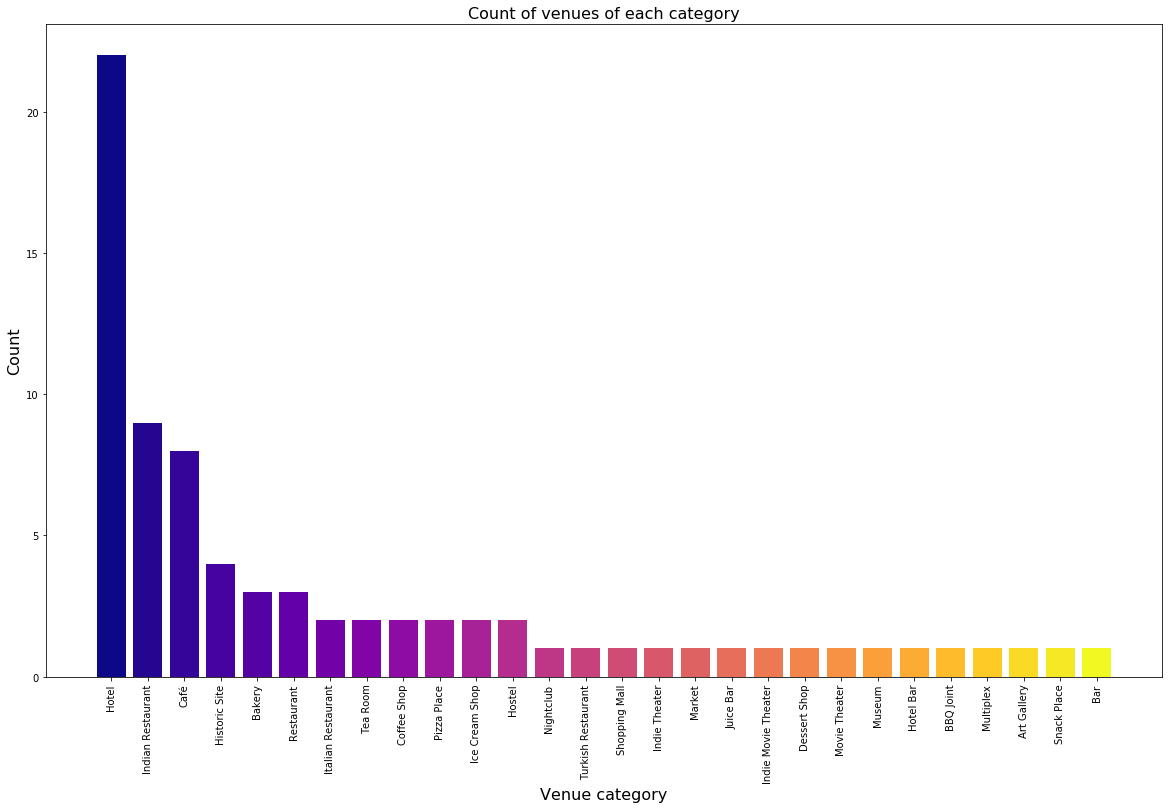

In [22]:
venue_distribution = selected_venues['categories'].value_counts()
plt.figure(figsize = (20, 12))
plt.xticks(rotation = 90)
plt.xlabel("Venue category", fontsize = 16)
plt.ylabel("Count", fontsize = 16)
plt.title("Count of venues of each category", fontsize = 16)
plt.bar(venue_distribution.index, venue_distribution.values, color = cm.plasma(np.linspace(0, 1, len(venue_distribution.index))))

As we can see the majority venues are Hotel, Cafe and Indian Restaurant. So, we can see that this is a great tourist place as it has large number of hotels and if anyone loves Cafes and Indian Restaurant Jaipur is great place to visit.

#### Rating

Rating
Rating of a venue can be an important factor on which a visitor decides whether it is worth it to visit the place or not. So to this, we will first see what is the average rating for all the venues in the city. Next, we will plot the venues on the map and color code them.
We'll first identify the various rating values and plot them as a bar plot with their counts to see the most common rating.

Text(0.5, 1.0, 'Count of venues with given rating')

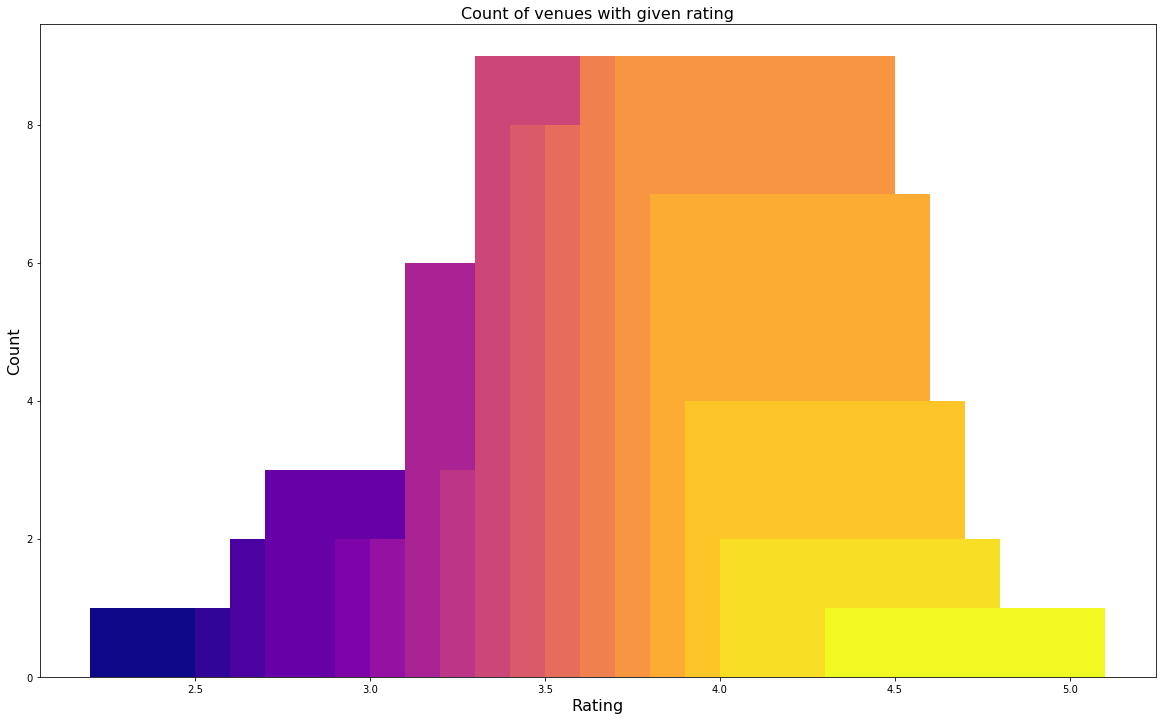

In [23]:
selected_venues['rating'] = selected_venues['rating'].astype(float)
rating = selected_venues['rating'].value_counts().sort_index()
plt.figure(figsize = (20, 12))
plt.bar(rating.index, rating.values, color = cm.plasma(np.linspace(0, 1, len(rating.index))))
plt.xlabel("Rating", fontsize = 16)
plt.ylabel("Count", fontsize = 16)
plt.title("Count of venues with given rating", fontsize = 16)

From the plot above, it is clear that majority venues have their rating between 3.5-4.5.

Let's create bins for various ratings and plot them in different colors on the map. The ratings will be divided between 4 bins:

1 to 2 - bin 1

2 to 3 - bin 2

3 to 4 - bin 3

4 to 5 - bin 4


In [24]:
bins = [1.0, 2.0, 3.0, 4.0, 5.0]
labels = ['Low', 'Okay', 'Good', 'Excellent']
selected_venues['rating_bin'] = pd.cut(selected_venues['rating'].astype(float), bins = bins, labels = labels, include_lowest = True)

Now, we will plot the venues on the map on the basis of ratings.

In [25]:
# colors for the different markers
color_map = {'Low': 'red', 'Okay': 'yellow', 'Good': 'green', 'Excellent': 'blue'}

jaipur_map = folium.Map(location = [jaipur_lat, jaipur_long], zoom_start = 13)

for name, address, latitude, longitude, rating_bin in zip(selected_venues['venue'], 
                                                          selected_venues['address'], 
                                                          selected_venues['latitude'], 
                                                          selected_venues['longitude'], 
                                                          selected_venues['rating_bin']):
    label = '{}, {}'.format(name, address)
    label = folium.Popup(label, parse_html = True)
    folium.Marker(
        [latitude, longitude],
        icon = folium.Icon(color = color_map[rating_bin]),
        popup = label).add_to(jaipur_map)  

jaipur_map.save("maps/Venues Ratings(Jaipur).html")
jaipur_map


The map has the location of all the venues. It appears that many venues are located near about MI Road, Adarsh Nagar, Bani Park with rating above 3. If someone wants to explore new venues, they should definitely check out these locations.

#### Price

We will now take a look the venues based on the price values. We have two price features for our venues, one is average_price which defines the average cost for one person and the other is price_range which determines the price range as defined by Zomato.

We will first explore the average_price using a scatter plot between the price and the count of venues with that average price. We'll size the points based on the price to highlight their price.

Text(0.5, 1.0, 'Count of venues with given average price')

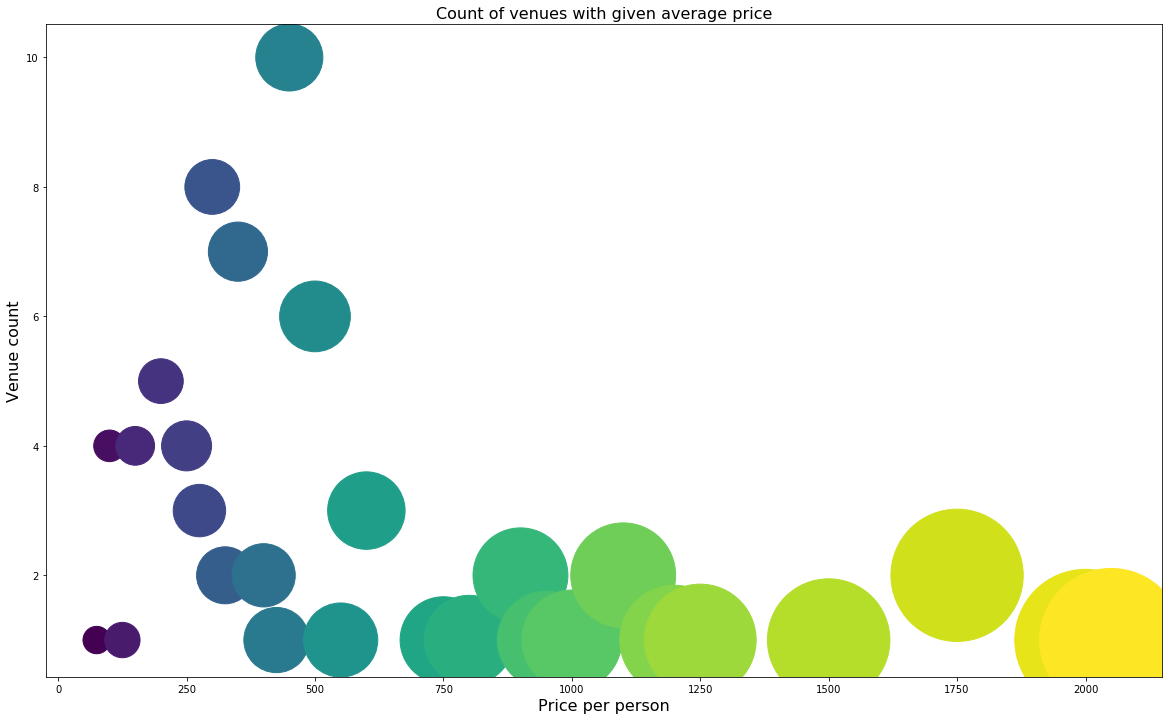

In [26]:
average_prices = selected_venues['average_price'].value_counts().sort_index()
plt.figure(figsize = (20, 12))
plt.scatter(average_prices.index, 
            average_prices.values, 
            s = average_prices.index*10, 
            c = cm.viridis(np.linspace(0, 1, len(average_prices.index)))) #c for different color ranges
plt.xlabel("Price per person", fontsize = 16)
plt.ylabel("Venue count", fontsize = 16)
plt.title("Count of venues with given average price", fontsize = 16)

From the plot above we can see that a large number of venues have an average price between Rs 200 and Rs 500.

Users might also be interested in going to a place that fits in their budget. So, I'll use the price_range column to plot the venues on a map. 

In [27]:
color_map = {'1.0': 'blue', '2.0': 'green', '3.0': 'yellow', '4.0': 'red'}

jaipur_map = folium.Map(location = [jaipur_lat, jaipur_long], zoom_start = 13)

for name, address, latitude, longitude, price_range in zip(selected_venues['venue'], 
                                                           selected_venues['address'], 
                                                           selected_venues['latitude'], 
                                                           selected_venues['longitude'], 
                                                           selected_venues['price_range'].astype(str)):
    #creating labels
    label = '{}, {}'.format(name, address)
    label = folium.Popup(label, parse_html = True)
    folium.Marker(
        [latitude, longitude],
        icon = folium.Icon(color = color_map[price_range]),
        popup = label).add_to(jaipur_map)  

#saving map
jaipur_map.save("maps/Venues Prices(Jaipur).html")
jaipur_map

The spots in Jaleb Chowk, MI Road, near Amer Road has high prices, while the spots in Khasa Kothi, Civil Lines and Bais Godam are of average price. As the places having high prices are near historical monuments so we can easily know the reasoin of their high average price.

#### Clustering

We will now cluster all these venues based on their price range, location and more to identify similar venues and the relationship amongst them. We'll cluster the venues into four separate groups.

In [28]:
no = 4
clustering = selected_venues.drop(['venue', 'address', 'rating_bin', 'categories'], 1)
kMeans = KMeans(n_clusters = no, random_state = 0).fit(clustering)
selected_venues.insert(0, 'cluster_labels', kMeans.labels_)
selected_venues.head(5)

,cluster_labels,categories,venue,latitude,longitude,price_range,rating,address,average_price,rating_bin
0,2,Tea Room,Nothing Before Coffee,26.91,75.81,1.0,4.2,"Opposite Mahaveer College Gate 2, Mahaveer Mar...",200.0,Excellent
1,2,Indie Movie Theater,The Doors,26.92,75.81,1.0,3.8,"Khandaka Mansion, Near Raj Mandir Cinema, MI R...",200.0,Good
2,3,Hotel,The Rajput Room - Rambagh Palace,26.90,75.81,4.0,4.2,"Rambagh Palace, Bhawani Singh Road, C Scheme, ...",2000.0,Excellent
3,0,Hostel,The Moustache Headquarters,26.92,75.80,2.0,3.9,"7, Park House, Near Ganpati Plaza, MI Road, Ja...",450.0,Good
4,2,Hotel,Chitra Cafeteria,26.92,75.80,2.0,4.0,"Arya Niwas Hotel, Behind Amber Towers, Sansar ...",275.0,Good


In [29]:
jaipur_map = folium.Map(location = [jaipur_lat, jaipur_long], zoom_start = 13)
color_map = { 0: 'black', 1: 'red', 2: 'yellow', 3: 'blue'}

# add venues to the map
markers_colors = []
for venue, address, cluster, latitude, longitude in zip(selected_venues['venue'], 
                                                        selected_venues['address'], 
                                                        selected_venues['cluster_labels'], 
                                                        selected_venues['latitude'], 
                                                        selected_venues['longitude']):
    label = folium.Popup(str(venue) + ', ' + str(address), parse_html = True)
    folium.CircleMarker(
        [latitude, longitude],
        radius = 5,
        popup = label,
        color = color_map[cluster],
        fill = True,
        fill_color = color_map[cluster],
        fill_opacity = 0.7).add_to(jaipur_map)

for index, cluster in enumerate(kMeans.cluster_centers_):
    latitude = cluster[0]
    longitude = cluster[1]
    label = folium.Popup("Cluster: " + str(index), parse_html = True)
    folium.CircleMarker(
        [latitude, longitude],
        radius = 10,
        popup = label,
        color = color_map[index],
        fill = True,
        fill_color = color_map[index],
        fill_opacity = 0.7).add_to(jaipur_map)

jaipur_map.save("maps/Venues Clusters(Jaipur).html")
jaipur_map

From the map we can see the 4 clusters, with large no. of fourth type of cluster with large no. of venues and  spread acroos the whole city.

Now, we will check the venues for different clusters.

In [30]:
result = selected_venues[selected_venues['cluster_labels'] == 0]
print("Cluster 0")
result.head(10).reset_index(drop = True)

Cluster 0


,cluster_labels,categories,venue,latitude,longitude,price_range,rating,address,average_price,rating_bin
0,0,Hostel,The Moustache Headquarters,26.92,75.80,2.0,3.9,"7, Park House, Near Ganpati Plaza, MI Road, Ja...",450.0,Good
1,0,Indian Restaurant,Peacock,26.92,75.80,2.0,4.2,"Hotel Pearl Palace, 51, Near Vidayakpuri Polic...",450.0,Excellent
2,0,Café,Peacock,26.92,75.80,2.0,4.2,"Hotel Pearl Palace, 51, Near Vidayakpuri Polic...",450.0,Excellent
3,0,Hostel,Heritage Above-1,26.93,75.83,2.0,3.3,"Chandi Ki Taksal, Hawa Mahal Road, Pink City, ...",350.0,Good
4,0,Tea Room,Tapri Central,26.89,75.80,2.0,4.7,"B4 E, 3rd Floor, Surana Jewellers, Opposite Ce...",400.0,Excellent
5,0,Café,Domino's Pizza,26.92,75.81,2.0,3.3,"C 18, Silver Square Mall, Bhagwandas Marg, C S...",350.0,Good
6,0,Hotel,On The Way,26.91,75.82,2.0,3.7,"5th Floor, Hotel While Lily, Diggy Palace Road...",350.0,Good
7,0,Café,Blue Tokai Coffee Roasters,26.91,75.80,2.0,4.3,"101, 1st Floor, Suryavanshi Pearl, A-5 Chomu H...",450.0,Excellent
8,0,Café,Mad'Ouk - Magic In Making,26.91,75.80,3.0,4.1,"J 26, Subhash Marg, C Scheme, Jaipur",500.0,Excellent
9,0,Café,Home Café by Mr Beans,26.91,75.79,3.0,4.1,"E 141 A, Sardar Patel Marg, C Scheme, Jaipur",500.0,Excellent


In [31]:
print("These spots for cluster 0 have mean price range of {:.02f} and rating spread around {:.02f}".
      format(result['price_range'].mean(), result['rating'].astype(float).mean()))

These spots for cluster 0 have mean price range of 2.33 and rating spread around 3.73


In [32]:
result = selected_venues[selected_venues['cluster_labels'] == 1]
print("Cluster 1")
result.head(10).reset_index(drop = True)

Cluster 1


,cluster_labels,categories,venue,latitude,longitude,price_range,rating,address,average_price,rating_bin
0,1,Historic Site,Baradari - City Palace,26.93,75.82,4.0,3.9,"The City Palace, Gate 2, Jaleb Chowk, Pink Cit...",1100.0,Good
1,1,Bar,Bar Palladio Jaipur,26.90,75.81,3.0,4.0,"Hotel Narain Niwas, Kanota Bagh, Narayan Singh...",900.0,Good
2,1,Bakery,On The House,26.91,75.79,3.0,4.3,"E 145, Ramesh Marg, Behind Talwalkars, C Schem...",750.0,Excellent
3,1,Hotel,Rasa,26.93,75.79,4.0,4.1,"Shahpura Hotels, D-257, Devi Marg, Bani Park, ...",1200.0,Excellent
4,1,Turkish Restaurant,Caffe Palladio Jaipur,26.90,75.82,4.0,3.8,"100, Near Trimurti Circle, J.LN. Marg, Santha ...",1000.0,Good
5,1,Hotel,Kloud - Royal Orchid Central,26.92,75.79,3.0,4.1,"Royal Orchid Central, A-26, A/2, Level 9, Jais...",900.0,Excellent
6,1,Hotel,Monarch Restaurant - Holiday Inn Jaipur City C...,26.90,75.79,3.0,4.4,"Holiday Inn Jaipur City Centre, Commercial Plo...",950.0,Excellent
7,1,Hotel,Mansagar - Trident Jaipur,26.96,75.84,4.0,3.1,"Trident Jaipur, Opposite Jal Mahal, Amer Road,...",1250.0,Good
8,1,Indian Restaurant,Handi Fusion,26.92,75.80,3.0,3.7,"Maya Mansion, Opposite GPO, MI Road, Jaipur",800.0,Good
9,1,Indian Restaurant,Niros,26.92,75.81,4.0,4.0,"319, Panch Batti, MI Road, Jaipur",1100.0,Good


In [33]:
print("These venues for cluster 1 have mean price range of {:.02f} and rating spread around {:.02f}".
      format(result['price_range'].mean(), result['rating'].astype(float).mean()))

These venues for cluster 1 have mean price range of 3.50 and rating spread around 3.94


In [34]:
result = selected_venues[selected_venues['cluster_labels'] == 2]
print("Cluster 2")
result.head(10).reset_index(drop = True)

Cluster 2


,cluster_labels,categories,venue,latitude,longitude,price_range,rating,address,average_price,rating_bin
0,2,Tea Room,Nothing Before Coffee,26.91,75.81,1.0,4.2,"Opposite Mahaveer College Gate 2, Mahaveer Mar...",200.0,Excellent
1,2,Indie Movie Theater,The Doors,26.92,75.81,1.0,3.8,"Khandaka Mansion, Near Raj Mandir Cinema, MI R...",200.0,Good
2,2,Hotel,Chitra Cafeteria,26.92,75.80,2.0,4.0,"Arya Niwas Hotel, Behind Amber Towers, Sansar ...",275.0,Good
3,2,Ice Cream Shop,Naturals Ice Cream,26.91,75.80,1.0,4.4,"A 5, Ground Floor, Suryavanshi Pearl, Sarder P...",75.0,Excellent
4,2,Ice Cream Shop,Jal Mahal Ice Cream Parlour,26.92,75.81,1.0,4.3,"85, MI Road, Jaipur",200.0,Excellent
5,2,Café,Curious Life Coffee Roasters- Deer Park,26.90,75.80,2.0,3.7,"P 25, Yudhister Marg, Opposite Deer Park, C Sc...",250.0,Good
6,2,Historic Site,Jaipur Dairy,26.91,75.80,1.0,3.4,"Near Statue Circle, C Scheme, Jaipur",100.0,Good
7,2,Juice Bar,Shreenath Lassiwala,26.92,75.81,1.0,3.9,"314, MI Road, Jaipur",100.0,Good
8,2,Bakery,Brown Sugar-Bakers & Cafe,26.91,75.81,2.0,4.1,"Axis Mall, Ground Floor, Bhagwan Das Road, C S...",325.0,Excellent
9,2,BBQ Joint,Old Take Away - The Kabab Shop,26.92,75.81,2.0,4.0,"146-149, Subhash Corner, MI Road, Jaipur",300.0,Good


In [35]:
print("These venues for cluster 2 have mean price range of {:.02f} and rating spread around {:.02f}".
      format(result['price_range'].mean(), result['rating'].astype(float).mean()))

These venues for cluster 2 have mean price range of 1.53 and rating spread around 3.82


In [37]:
result = selected_venues[selected_venues['cluster_labels'] == 3]
print("Cluster 3")
result.head(10).reset_index(drop = True)

Cluster 3


,cluster_labels,categories,venue,latitude,longitude,price_range,rating,address,average_price,rating_bin
0,3,Hotel,The Rajput Room - Rambagh Palace,26.90,75.81,4.0,4.2,"Rambagh Palace, Bhawani Singh Road, C Scheme, ...",2000.0,Excellent
1,3,Hotel,Samode Haveli Restaurant,26.93,75.84,4.0,3.9,"Samode Haveli, Gangapole, Amer Road, Jaipur",1750.0,Good
2,3,Indian Restaurant,Peshawri - ITC Rajputana Hotel,26.92,75.79,4.0,4.3,"ITC Rajputana Hotel, Palace Road, Gopalbari, J...",1500.0,Excellent
3,3,Hotel,Jal Mahal - ITC Rajputana Hotel,26.92,75.79,4.0,4.1,"ITC Rajputana Hotel, Palace Road, Gopalbari, J...",1750.0,Excellent
4,3,Hotel Bar,The Polo Bar - Rambagh Palace,26.90,75.81,4.0,3.9,"Rambagh Palace, Bhawani Singh Road, C Scheme, ...",2050.0,Good


In [38]:
print("These venues for cluster 3 have mean price range of {:.02f} and rating spread around {:.02f}".
      format(result['price_range'].mean(), result['rating'].astype(float).mean()))

These venues for cluster 3 have mean price range of 4.00 and rating spread around 4.08


## 6. Results

Based on our analysis above, we can draw a number of conclusions that will be useful who is visiting the city Jaipur and planning to start something.

After collecting data from the Foursquare and Zomato APIs, I got a list of 100 different venues. However, not all venues from the two APIs were identical. Hence, we had to inspect their latitude and longitude values as well as names to combine them and remove all the outliers. 

We identified that from the total set of venues, majority of them were Hotels, Cafes and Indian Restaurants.

While the complete range of ratings range from 1 to 5, the majority venues have ratings between 3.5 to 4.5. This means that most restaurants provide good quality food which is liked by the people of the city, thus indicating the high rating. When we plot these venues on the map, we discover that there are clusters of venues around MI Road, Adarsh Nagar, Bani Park. These clusters also have very high ratings (more than 3).

When we take a look at the price values of each venue, we explore that many venues have prices which are in the range of Rs 200 to Rs 400 for one person. However, the variation in prices is very large, given the complete range starts from Rs 100 and goes uptil Rs 2000. On plotting the venues based on their price range on the map, we discovered that the spots in Jaleb Chowk, MI Road, near Amer Road has high prices, while the spots in Khasa Kothi, Civil Lines and Bais Godam are of average price. As the places having high prices are near historical monuments so we can easily know the reason of their high average price.

Finally, through clusters we identified that there are many venues in 3 different clusters which are relatively lower priced with an average rating of 3.82-3.95. On the other hand, there are few venues in a particular cluster i.e. last cluster(Cluster 3) which are high priced and have average rating of 4.08.

A company can use this information to build up an online website/mobile application, to provide users with up to date information about various venues in the city based on the search criteria (name, rating and price).
An an entrepreneur can also use this information to open a new cafe, hotel, restaurant and other venues in Jaipur.

## 7. Conclusion and Future Scope

The purpose of this project was to explore the places that a person visiting Jaipur could visit. The venues have been identified using Foursquare and Zomato API and have been plotted on the map. Based on the visitor's venue rating and price requirements, he/she can choose amongst the three places.

And we can also improve this project in future by taking in concern other factors also population, etc. And we can extend it to whole city Jaipur and to other cities also.

#### Note - As github does not render the maps so you can view the maps in the maps folder of this repo.